In [1]:
import sys
import pennylane as qml
from pennylane import numpy as np
from math import pi
from sklearn import datasets
import scipy
import numpy as np
import time
import math

In [2]:
numQubits = 4
numParametrisedLayers = 2
d = numQubits * numParametrisedLayers

In [3]:
dev = qml.device("default.qubit", wires=numQubits)

In [4]:
iris = datasets.load_iris()
X = iris.data[:, :][0:100]
y = iris.target[0:100]

In [5]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [6]:
def add_layerRZ(data):
    for i in range(numQubits):
        qml.RZ(data[i], wires = i)

def add_layerRZZ(data):
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])
            qml.RZ((pi-data[i])*(pi-data[j]), wires = j)
            qml.CNOT(wires = [i, j])

def make_feature_map(data):
    for i in range(numQubits):
        qml.Hadamard(wires = i)
    add_layerRZ(data)
    add_layerRZZ(data)

In [7]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])

def add_layerRY(params):
    for qubit in range(numQubits):
        qml.RY(params[qubit], wires = qubit)
        
def make_variationalCircuit(params):
    add_layerRY(params[0:numQubits])
    add_cnots()
    add_layerRY(params[numQubits:])

In [8]:
def make_final_circuit(data, params):
    make_feature_map(data)
    make_variationalCircuit(params)

In [9]:
@qml.qnode(dev)
def qnode(params):
    make_final_circuit(data, params)
    return qml.expval(qml.PauliX(1))

In [10]:
@qml.qnode(dev)
def fubini_qnode(data, params):
    make_final_circuit(data, params)
    return qml.state()

In [11]:
def fubini_calculate(data, params):
    fubini = np.zeros([d, d], dtype=np.float64)
    base = np.conj(fubini_qnode(data,params))
    for i in range(d):
        for j in range(d):
            params[i] += np.pi/2
            params[j] += np.pi/2
            plusplus = np.abs(np.dot(base, fubini_qnode(data, params))) ** 2
            params[j] -= np.pi
            plusminus = np.abs(np.dot(base, fubini_qnode(data, params))) ** 2
            params[i] -= np.pi
            minusminus = np.abs(np.dot(base, fubini_qnode(data, params))) ** 2
            params[j] += np.pi
            minusplus = np.abs(np.dot(base, fubini_qnode(data, params))) ** 2
            fubini[i, j] = (-plusplus-minusminus+plusminus+minusplus)/8
            params[i] += np.pi/2
            params[j] -= np.pi/2
    return fubini

In [12]:
def V_theta():
    return (2*pi)**(d)

In [13]:
def normalised_matrix(fisher_matrix):
    denominator = ((2*pi)**d)*np.trace(fisher_matrix)          
    return d*(V_theta()/denominator)*fisher_matrix

In [14]:
def effective_dimension(n, gamma, fisher_matrix):
    factor = (gamma*n)/(2*pi*math.log10(n))
    determinant = np.linalg.det(factor*normalised_matrix(fisher_matrix) + np.identity(fisher_matrix.shape[0]))
    integrate_det = ((2*pi)**d)*determinant**0.5
    return 2*math.log10(integrate_det/V_theta())/math.log10(factor)

In [15]:
fubini_matrices = []
effective_dim_eigen = []
effective_dim_formula = []
gamma = 0.5
n = 10**6
cutoff_eigvals = 10**(-12)

In [19]:
start_qfi = time.time()

for i in range(len(X)) :
    data = normalize(X[i])
    np.random.seed(0)
    params = np.random.uniform(-1, 1, d)
    
    fubini = fubini_calculate(data, params)
    fubini_matrices.append(fubini)
    eigvals,eigvecs=scipy.linalg.eigh(fubini)
    nonzero_eigvals=eigvals[eigvals>cutoff_eigvals]
    eff_dim=len(nonzero_eigvals)
    eff_dim_form = effective_dimension(n, gamma, fubini)
    effective_dim_eigen.append(eff_dim)
    effective_dim_formula.append(eff_dim_form)
    
end_qfi = time.time()
print(end_qfi - start_qfi)

158.0858883857727


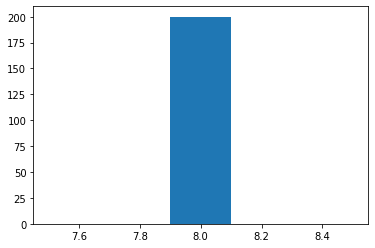

In [20]:
import matplotlib.pyplot as plt
plt.hist(effective_dim_eigen, bins = 5)
plt.show()

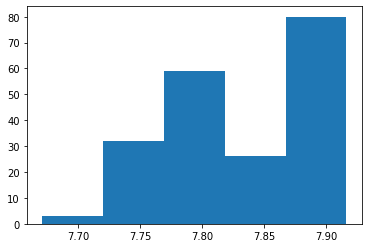

In [21]:
import matplotlib.pyplot as plt
plt.hist(effective_dim_formula, bins = 5)
plt.show()